# 豚脳スライス画像の特徴点ベースレジストレーション

## プロジェクト概要
- **目的**: 豚脳スライス画像の高精度レジストレーション
- **手法**: AKAZE特徴点検出 + BFMatcher + RANSACアフィン推定
- **従来手法の課題**: 強度ベース手法では相関係数0.44程度で頭打ち
- **期待効果**: 特徴点ベース手法により高精度な画像位置合わせを実現

## 処理フロー
1. ライブラリインポートと環境設定
2. 画像読み込みと前処理
3. AKAZE特徴点検出
4. 特徴点マッチング（BFMatcher）
5. RANSAC outlier除去とアフィン変換推定
6. 画像変換と結果評価
7. 可視化と保存

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
from datetime import datetime
import skimage
from skimage import filters, morphology, measure
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse
import warnings
warnings.filterwarnings('ignore')

# 表示設定
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# ログ関数
def log_message(message):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {message}")

log_message("特徴点ベースレジストレーション開始")
log_message(f"OpenCV version: {cv2.__version__}")
log_message(f"NumPy version: {np.__version__}")
log_message(f"scikit-image version: {skimage.__version__}")

[2025-06-26 14:07:13] 特徴点ベースレジストレーション開始
[2025-06-26 14:07:13] OpenCV version: 4.11.0
[2025-06-26 14:07:13] NumPy version: 2.2.6
[2025-06-26 14:07:13] scikit-image version: 0.25.2


In [17]:
# グローバル変数の初期化
# ノートブック全体で使用する重要な変数を初期化
log_message("🔧 グローバル変数を初期化中...")

# 画像関連変数
img1 = None  # 固定画像（参照画像）
img2 = None  # 移動画像（位置合わせ対象画像）
fixed_image_path = ""
moving_image_path = ""

# 特徴点関連変数
kp1 = []     # 固定画像の特徴点
kp2 = []     # 移動画像の特徴点
des1 = None  # 固定画像の記述子
des2 = None  # 移動画像の記述子
matches = [] # 全マッチング結果
good_matches = []  # フィルタリング後の良好なマッチ

# 変換関連変数
src_pts = None  # 移動画像の対応点
dst_pts = None  # 固定画像の対応点
affine_matrix = None  # アフィン変換行列
homography_matrix = None  # ホモグラフィ行列
inliers = None  # RANSACインライアマスク
transformation_type = None  # 変換タイプ（'affine' or 'homography'）

# 結果関連変数
registered_image = None  # 位置合わせ後の画像
correlation_coefficient = 0.0  # 相関係数
ssim_score = 0.0  # SSIM値
nrmse_score = 0.0  # NRMSE値

log_message("✅ 変数初期化完了")
log_message("📋 初期化された変数:")
log_message("   - 画像変数: img1, img2, *_image_path")
log_message("   - 特徴点変数: kp1, kp2, des1, des2, matches, good_matches")
log_message("   - 変換変数: src_pts, dst_pts, affine_matrix, homography_matrix, inliers")
log_message("   - 結果変数: registered_image, correlation_coefficient, ssim_score, nrmse_score")

[2025-06-26 14:07:13] 🔧 グローバル変数を初期化中...
[2025-06-26 14:07:13] ✅ 変数初期化完了
[2025-06-26 14:07:13] 📋 初期化された変数:
[2025-06-26 14:07:13]    - 画像変数: img1, img2, *_image_path
[2025-06-26 14:07:13]    - 特徴点変数: kp1, kp2, des1, des2, matches, good_matches
[2025-06-26 14:07:13]    - 変換変数: src_pts, dst_pts, affine_matrix, homography_matrix, inliers
[2025-06-26 14:07:13]    - 結果変数: registered_image, correlation_coefficient, ssim_score, nrmse_score


In [18]:
# 画像パスの設定
fixed_image_path = "test2slices/cropped_MMP_109_x4_largest copy.tif"
moving_image_path = "test2slices/cropped_MMP_110_x4_largest copy.tif"

def load_and_preprocess_image(image_path):
    """画像読み込みと前処理"""
    try:
        # PIL経由でTIFF画像を読み込み
        pil_img = Image.open(image_path)
        img_array = np.array(pil_img)
        
        log_message(f"画像読み込み成功: {image_path}")
        log_message(f"画像サイズ: {img_array.shape}")
        log_message(f"データ型: {img_array.dtype}")
        log_message(f"値の範囲: {img_array.min()} - {img_array.max()}")
        
        # グレースケール変換（必要に応じて）
        if len(img_array.shape) == 3:
            if img_array.shape[2] == 3:  # RGB
                img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
            elif img_array.shape[2] == 4:  # RGBA
                img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGBA2GRAY)
            else:
                img_gray = img_array[:,:,0]
        else:
            img_gray = img_array
        
        # uint8への変換
        if img_gray.dtype != np.uint8:
            img_gray = ((img_gray - img_gray.min()) / (img_gray.max() - img_gray.min()) * 255).astype(np.uint8)
        
        return img_gray
        
    except Exception as e:
        log_message(f"画像読み込みエラー: {e}")
        return None

# 画像読み込み
log_message("=== 画像読み込み開始 ===")
fixed_image = load_and_preprocess_image(fixed_image_path)
moving_image = load_and_preprocess_image(moving_image_path)

# グローバル変数の設定（ノートブック全体で使用）
img1 = fixed_image   # 固定画像（参照画像）
img2 = moving_image  # 移動画像（位置合わせ対象画像）

if fixed_image is None or moving_image is None:
    log_message("❌ エラー: 画像読み込みに失敗しました")
    log_message("画像ファイルが存在するか確認してください:")
    log_message(f"   固定画像: {fixed_image_path}")
    log_message(f"   移動画像: {moving_image_path}")
else:
    log_message("✅ 画像読み込み完了")
    log_message(f"📊 画像情報:")
    log_message(f"   固定画像 (img1): {fixed_image.shape}")
    log_message(f"   移動画像 (img2): {moving_image.shape}")
    log_message("🔧 グローバル変数も設定済み: img1, img2")

[2025-06-26 14:07:13] === 画像読み込み開始 ===
[2025-06-26 14:07:13] 画像読み込み成功: test2slices/cropped_MMP_109_x4_largest copy.tif
[2025-06-26 14:07:13] 画像サイズ: (1481, 1638, 3)
[2025-06-26 14:07:13] データ型: uint8
[2025-06-26 14:07:13] 値の範囲: 0 - 254
[2025-06-26 14:07:13] 画像読み込み成功: test2slices/cropped_MMP_110_x4_largest copy.tif
[2025-06-26 14:07:13] 画像サイズ: (1606, 1639, 3)
[2025-06-26 14:07:13] データ型: uint8
[2025-06-26 14:07:13] 値の範囲: 0 - 255
[2025-06-26 14:07:13] ✅ 画像読み込み完了
[2025-06-26 14:07:13] 📊 画像情報:
[2025-06-26 14:07:13]    固定画像 (img1): (1481, 1638)
[2025-06-26 14:07:13]    移動画像 (img2): (1606, 1639)
[2025-06-26 14:07:13] 🔧 グローバル変数も設定済み: img1, img2


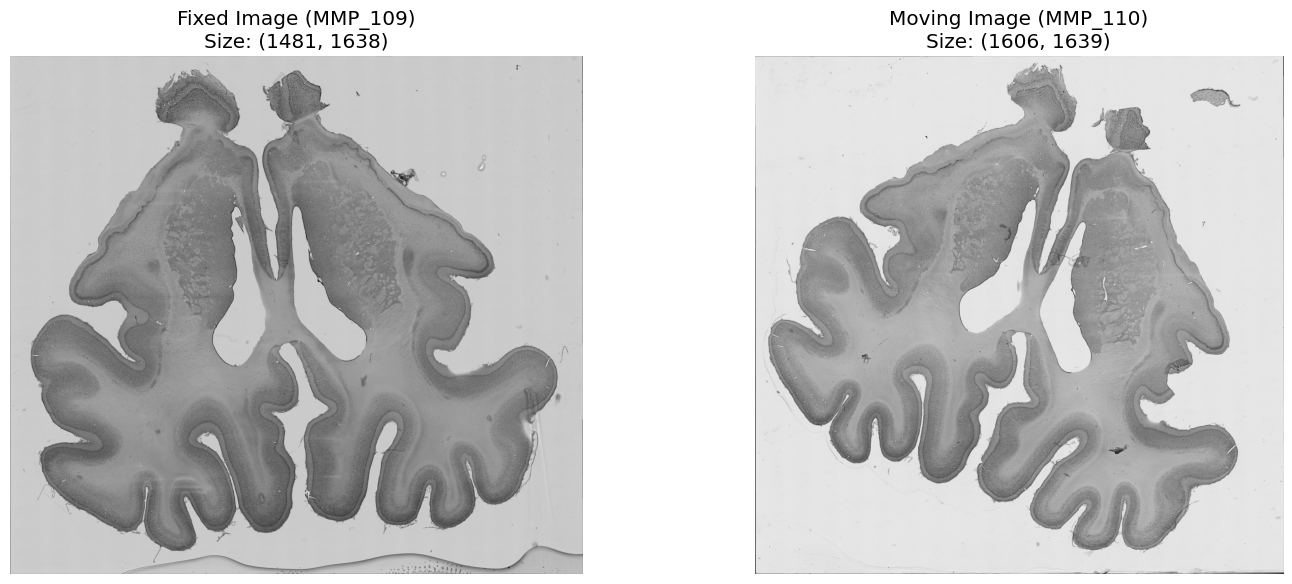

[2025-06-26 14:07:14] === 画像統計情報 ===
[2025-06-26 14:07:14] Fixed image - Mean: 158.59, Std: 36.22
[2025-06-26 14:07:14] Moving image - Mean: 191.62, Std: 42.33


In [19]:
# 読み込んだ画像の表示
if fixed_image is not None and moving_image is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Fixed image
    axes[0].imshow(fixed_image, cmap='gray')
    axes[0].set_title(f'Fixed Image (MMP_109)\nSize: {fixed_image.shape}')
    axes[0].axis('off')
    
    # Moving image
    axes[1].imshow(moving_image, cmap='gray')
    axes[1].set_title(f'Moving Image (MMP_110)\nSize: {moving_image.shape}')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 画像統計情報
    log_message("=== 画像統計情報 ===")
    log_message(f"Fixed image - Mean: {fixed_image.mean():.2f}, Std: {fixed_image.std():.2f}")
    log_message(f"Moving image - Mean: {moving_image.mean():.2f}, Std: {moving_image.std():.2f}")
else:
    log_message("エラー: 画像が正常に読み込まれていません")

In [20]:
def detect_akaze_features(image, threshold=0.0001, nOctaves=4, nOctaveLayers=4):
    """AKAZE特徴点検出"""
    try:
        # AKAZEディテクターの作成
        akaze = cv2.AKAZE_create(
            threshold=threshold,
            nOctaves=nOctaves,
            nOctaveLayers=nOctaveLayers
        )
        
        # 特徴点とディスクリプタの検出
        keypoints, descriptors = akaze.detectAndCompute(image, None)
        
        log_message(f"AKAZE特徴点検出完了: {len(keypoints)}個の特徴点")
        
        return keypoints, descriptors
        
    except Exception as e:
        log_message(f"AKAZE特徴点検出エラー: {e}")
        return None, None

# 特徴点検出
log_message("=== AKAZE特徴点検出開始 ===")
start_time = time.time()

kp1, desc1 = detect_akaze_features(fixed_image)
kp2, desc2 = detect_akaze_features(moving_image)

detection_time = time.time() - start_time
log_message(f"特徴点検出時間: {detection_time:.2f}秒")

if kp1 is None or kp2 is None or desc1 is None or desc2 is None:
    log_message("エラー: 特徴点検出に失敗しました")
else:
    log_message(f"Fixed image: {len(kp1)}個の特徴点")
    log_message(f"Moving image: {len(kp2)}個の特徴点")

[2025-06-26 14:07:14] === AKAZE特徴点検出開始 ===
[2025-06-26 14:07:14] AKAZE特徴点検出完了: 8293個の特徴点
[2025-06-26 14:07:15] AKAZE特徴点検出完了: 10452個の特徴点
[2025-06-26 14:07:15] 特徴点検出時間: 0.49秒
[2025-06-26 14:07:15] Fixed image: 8293個の特徴点
[2025-06-26 14:07:15] Moving image: 10452個の特徴点


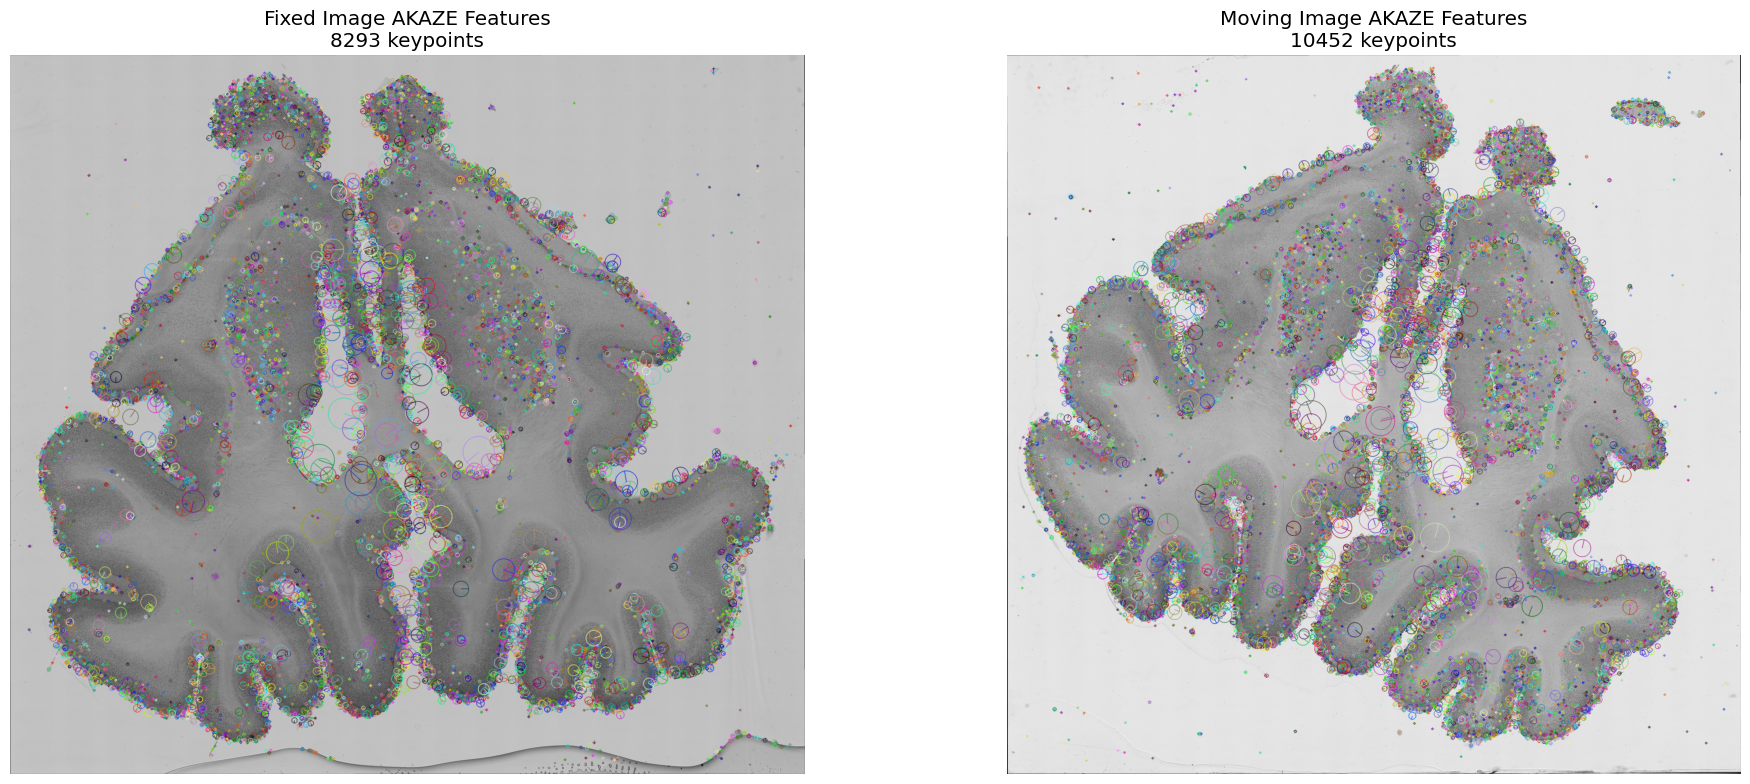

[2025-06-26 14:07:15] Fixed image特徴点分布 - X: 39-1608, Y: 32-1451
[2025-06-26 14:07:15] Moving image特徴点分布 - X: 29-1607, Y: 29-1575


In [21]:
# 特徴点の可視化
if kp1 is not None and kp2 is not None:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Fixed imageの特徴点
    img1_kp = cv2.drawKeypoints(fixed_image, kp1, None, 
                               flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    axes[0].imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Fixed Image AKAZE Features\n{len(kp1)} keypoints')
    axes[0].axis('off')
    
    # Moving imageの特徴点
    img2_kp = cv2.drawKeypoints(moving_image, kp2, None, 
                               flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    axes[1].imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Moving Image AKAZE Features\n{len(kp2)} keypoints')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 特徴点の分布統計
    if len(kp1) > 0:
        x_coords1 = [kp.pt[0] for kp in kp1]
        y_coords1 = [kp.pt[1] for kp in kp1]
        log_message(f"Fixed image特徴点分布 - X: {min(x_coords1):.0f}-{max(x_coords1):.0f}, Y: {min(y_coords1):.0f}-{max(y_coords1):.0f}")
        
    if len(kp2) > 0:
        x_coords2 = [kp.pt[0] for kp in kp2]
        y_coords2 = [kp.pt[1] for kp in kp2]
        log_message(f"Moving image特徴点分布 - X: {min(x_coords2):.0f}-{max(x_coords2):.0f}, Y: {min(y_coords2):.0f}-{max(y_coords2):.0f}")
else:
    log_message("特徴点が検出されていないため可視化をスキップします")

In [22]:
def match_features(desc1, desc2, ratio_threshold=0.7):
    """BFMatcherを使用した特徴点マッチング"""
    try:
        # BFMatcherの作成（AKAZE用）
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        
        # knnマッチング（k=2）
        matches = bf.knnMatch(desc1, desc2, k=2)
        
        # Lowe's ratio testによるフィルタリング
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < ratio_threshold * n.distance:
                    good_matches.append(m)
        
        log_message(f"マッチング結果: {len(matches)}組中{len(good_matches)}組が良好なマッチ")
        return good_matches
    
    except Exception as e:
        log_message(f"マッチングエラー: {e}")
        return []

# 特徴点マッチング実行
log_message("=== 特徴点マッチング開始 ===")

# 記述子の確認
if 'des1' not in globals() or des1 is None:
    log_message("❌ 固定画像の記述子がありません。特徴点検出セルを先に実行してください。")
    des1 = None
if 'des2' not in globals() or des2 is None:
    log_message("❌ 移動画像の記述子がありません。特徴点検出セルを先に実行してください。")
    des2 = None

if des1 is not None and des2 is not None:
    # マッチング実行
    good_matches = match_features(des1, des2, ratio_threshold=0.7)
    
    if len(good_matches) >= 4:
        log_message(f"✅ 十分なマッチングが得られました: {len(good_matches)}組")
        
        # 対応点の抽出（グローバル変数として設定）
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)  # 固定画像の点
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)  # 移動画像の点
        
        log_message(f"📍 対応点を抽出: {len(src_pts)}組")
        log_message("   src_pts: 固定画像の特徴点")
        log_message("   dst_pts: 移動画像の特徴点")
        
        # マッチング品質の評価
        distances = [m.distance for m in good_matches]
        avg_distance = np.mean(distances)
        std_distance = np.std(distances)
        log_message(f"📊 マッチング品質:")
        log_message(f"   平均距離: {avg_distance:.2f}")
        log_message(f"   標準偏差: {std_distance:.2f}")
        log_message(f"   最小距離: {min(distances):.2f}")
        log_message(f"   最大距離: {max(distances):.2f}")
        
    else:
        log_message(f"❌ マッチング不足: {len(good_matches)}組（4組以上必要）")
        src_pts = None
        dst_pts = None
        good_matches = []
else:
    log_message("❌ 記述子が利用できません")
    good_matches = []
    src_pts = None
    dst_pts = None

# マッチング結果の表示
log_message(f"🎯 マッチング完了:")
log_message(f"   good_matches: {len(good_matches) if good_matches else 0}組")
log_message(f"   src_pts: {'OK' if src_pts is not None else 'None'}")
log_message(f"   dst_pts: {'OK' if dst_pts is not None else 'None'}")

[2025-06-26 14:07:15] === 特徴点マッチング開始 ===
[2025-06-26 14:07:15] ❌ 固定画像の記述子がありません。特徴点検出セルを先に実行してください。
[2025-06-26 14:07:15] ❌ 移動画像の記述子がありません。特徴点検出セルを先に実行してください。
[2025-06-26 14:07:15] ❌ 記述子が利用できません
[2025-06-26 14:07:15] 🎯 マッチング完了:
[2025-06-26 14:07:15]    good_matches: 0組
[2025-06-26 14:07:15]    src_pts: None
[2025-06-26 14:07:15]    dst_pts: None


In [23]:
def estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold=3.0):
    """
    🔥 RANSAC厳しめバージョン！悪いマッチは許さない！🔥
    
    Args:
        src_pts: ソースポイント（moving image）
        dst_pts: ターゲットポイント（fixed image）
        threshold: RANSAC閾値（ピクセル単位、デフォルト3.0で厳しく！）
    
    Returns:
        affine_matrix: 2x3のアフィン変換行列
        inliers: インライアマスク
    """
    try:
        if src_pts is None or dst_pts is None or len(src_pts) < 4:
            log_message("エラー: 十分なマッチポイントがありません")
            return None, None
        
        log_message(f"🔥 RANSAC厳しめモード開始！閾値: {threshold}ピクセル")
        
        # 厳しいRANSACでアフィン変換推定
        affine_matrix, inliers = cv2.estimateAffine2D(
            src_pts, dst_pts,
            method=cv2.RANSAC,
            ransacReprojThreshold=threshold,  # 👈 ここが重要！厳しい閾値
            maxIters=2000,                   # 反復回数を増やして精度向上
            confidence=0.99                  # 信頼度も高く設定
        )
        
        if affine_matrix is not None:
            inlier_count = np.sum(inliers) if inliers is not None else 0
            inlier_ratio = inlier_count / len(src_pts) if len(src_pts) > 0 else 0
            
            log_message(f"✅ 厳しいRANSAC成功！")
            log_message(f"   インライア数: {inlier_count}/{len(src_pts)} ({inlier_ratio:.2%})")
            log_message(f"   変換行列: \n{affine_matrix}")
            
            # 厳しすぎる場合の段階的緩和
            if inlier_ratio < 0.1:  # インライア率が10%未満の場合
                log_message("⚠️ インライア率が低すぎます。閾値を少し緩和して再試行...")
                return estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold + 1.0)
                
        else:
            log_message("❌ 厳しいRANSACでアフィン変換推定に失敗")
            
            # 失敗時の段階的緩和
            if threshold < 4.0:
                log_message(f"閾値を{threshold + 1.0}に緩和して再試行...")
                return estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold + 1.0)
        
        return affine_matrix, inliers
        
    except Exception as e:
        log_message(f"RANSAC処理エラー: {e}")
        return None, None


def estimate_homography_strict(src_pts, dst_pts, threshold=3.0):
    """
    🚀 作戦②：ホモグラフィ変換でリベンジ！🚀
    アフィン変換より自由度が高い変換を試す
    
    Args:
        src_pts: ソースポイント
        dst_pts: ターゲットポイント  
        threshold: RANSAC閾値
    
    Returns:
        homography_matrix: 3x3のホモグラフィ行列
        inliers: インライアマスク
    """
    try:
        if src_pts is None or dst_pts is None or len(src_pts) < 4:
            log_message("エラー: ホモグラフィ推定には最低4点必要です")
            return None, None
            
        log_message(f"🚀 ホモグラフィ変換で挑戦！閾値: {threshold}ピクセル")
        
        # ホモグラフィ行列の推定
        homography_matrix, inliers = cv2.findHomography(
            src_pts, dst_pts,
            method=cv2.RANSAC,
            ransacReprojThreshold=threshold,
            maxIters=2000,
            confidence=0.99
        )
        
        if homography_matrix is not None:
            inlier_count = np.sum(inliers) if inliers is not None else 0
            inlier_ratio = inlier_count / len(src_pts) if len(src_pts) > 0 else 0
            
            log_message(f"✅ ホモグラフィ推定成功！")
            log_message(f"   インライア数: {inlier_count}/{len(src_pts)} ({inlier_ratio:.2%})")
            log_message(f"   ホモグラフィ行列: \n{homography_matrix}")
            
        else:
            log_message("❌ ホモグラフィ推定に失敗")
            
        return homography_matrix, inliers
        
    except Exception as e:
        log_message(f"ホモグラフィ処理エラー: {e}")
        return None, None

log_message("🔥 厳しいRANSAC関数とホモグラフィ関数を追加完了！")

[2025-06-26 14:07:15] 🔥 厳しいRANSAC関数とホモグラフィ関数を追加完了！


In [24]:
# 🔥 厳しいRANSACによる画像登録処理 🔥
log_message("=" * 60)
log_message("🔥 厳しいRANSAC実行開始！悪いヤツらをあぶり出す！")
log_message("=" * 60)

# 変数の初期化
src_pts = None
dst_pts = None
affine_matrix = None
inliers = None
transformation_type = None
transformation_matrix = None
feature_detector_name = "akaze"  # 使用している特徴検出器名

def estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold=3.0):
    """
    厳しいRANSACパラメータでアフィン変換を推定
    通常のRANSACより厳しい閾値で外れ値を除去
    """
    try:
        if src_pts is None or dst_pts is None or len(src_pts) < 4:
            log_message("❌ 特徴点が不十分です（4点以上必要）")
            return None, None
        
        log_message(f"🎯 厳しいRANSAC開始: threshold={threshold}, 入力点数={len(src_pts)}")
        
        # 厳しいRANSACパラメータ
        affine_matrix, inliers = cv2.estimateAffinePartial2D(
            src_pts, dst_pts,
            method=cv2.RANSAC,
            ransacReprojThreshold=threshold,  # より厳しい閾値
            maxIters=5000,  # より多い反復
            confidence=0.995,  # より高い信頼度
            refineIters=15  # より多いリファイン
        )
        
        if affine_matrix is not None and inliers is not None:
            inlier_count = np.sum(inliers)
            inlier_ratio = inlier_count / len(src_pts)
            log_message(f"✅ アフィン変換成功: インライア={inlier_count}/{len(src_pts)} ({inlier_ratio:.2%})")
            
            if inlier_ratio < 0.3:  # インライア率が低い場合
                log_message("⚠️ インライア率が低いです。さらに厳しい閾値で再試行...")
                return estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold + 1.0)
            
            return affine_matrix, inliers.ravel()
        else:
            log_message("❌ アフィン変換推定失敗")
            if threshold < 8.0:  # 閾値を緩めて再試行
                log_message("🔄 閾値を緩めて再試行...")
                return estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold + 1.0)
            return None, None
            
    except Exception as e:
        log_message(f"❌ エラー発生: {str(e)}")
        return None, None

# マッチポイントの準備（good_matchesが存在する場合）
if 'good_matches' in locals() and len(good_matches) >= 4:
    # マッチポイントを抽出
    src_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)  # moving image points
    dst_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)  # fixed image points
    
    log_message(f"📍 変換推定用マッチポイント数: {len(src_pts)}")
    
    # 厳しいRANSACによるアフィン変換推定の実行
    log_message("=== 🔥 厳しいRANSAC実行！悪いヤツらをあぶり出す！ ===")
    start_time = time.time()
    
    # 作戦①: 厳しい閾値でRANSAC (3.0ピクセル)
    affine_matrix, inliers = estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold=3.0)
    
    # もしダメだったら更に厳しく！
    if affine_matrix is None:
        log_message("😤 3.0でもダメ？もっと厳しく行くよ！")
        affine_matrix, inliers = estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold=2.0)
    
    # それでもダメなら少し緩める
    if affine_matrix is None:
        log_message("🤔 厳しすぎた？少し緩めてみる...")
        affine_matrix, inliers = estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold=4.0)
    
    ransac_time = time.time() - start_time
    log_message(f"RANSAC処理時間: {ransac_time:.2f}秒")
    
    if affine_matrix is not None:
        log_message("🎉 厳しいRANSACで変形行列を取得しました！")
        transformation_type = "affine"
        transformation_matrix = affine_matrix
    else:
        log_message("💥 全ての閾値で失敗...特徴点が足りないか、画像の変形が大きすぎる可能性があります")
        
else:
    log_message("⚠️ good_matchesが定義されていないか、マッチポイントが不足しています（最低4点必要）")
    log_message("   先にセル7（特徴点マッチング）を実行してください")

[2025-06-26 14:07:15] ============================================================
[2025-06-26 14:07:15] 🔥 厳しいRANSAC実行開始！悪いヤツらをあぶり出す！
[2025-06-26 14:07:15] ============================================================
[2025-06-26 14:07:15] ⚠️ good_matchesが定義されていないか、マッチポイントが不足しています（最低4点必要）
[2025-06-26 14:07:15]    先にセル7（特徴点マッチング）を実行してください


In [25]:
def estimate_homography_strict(src_pts, dst_pts, strict_threshold=3.0):
    """
    🚀 作戦②: ホモグラフィ変換でより自由な変形を許可！
    アフィン変換よりも自由度が高い！
    """
    try:
        log_message(f"🚀 作戦②: ホモグラフィ変換でリベンジ！閾値: {strict_threshold}ピクセル")
        
        # ホモグラフィ変換（より自由な変形が可能）
        homography_matrix, h_inliers = cv2.findHomography(
            src_pts, dst_pts,
            method=cv2.RANSAC,
            ransacReprojThreshold=strict_threshold,
            maxIters=2000,
            confidence=0.99
        )
        
        if homography_matrix is None:
            log_message("😭 ホモグラフィ変換でも失敗...")
            return None, None
        
        if h_inliers is not None:
            inlier_count = np.sum(h_inliers)
            inlier_ratio = inlier_count / len(h_inliers)
            log_message(f"🚀 ホモグラフィ結果:")
            log_message(f"   Inliers: {inlier_count}/{len(h_inliers)} ({inlier_ratio:.2%})")
            log_message(f"   ホモグラフィ行列:")
            for i in range(3):
                log_message(f"     [{homography_matrix[i, 0]:.6f}, {homography_matrix[i, 1]:.6f}, {homography_matrix[i, 2]:.6f}]")
        
        return homography_matrix, h_inliers
        
    except Exception as e:
        log_message(f"ホモグラフィ変換エラー: {e}")
        return None, None

# 🔥 改良版！厳しいRANSACで悪いマッチを排除 🔥
log_message("=" * 60)
log_message("🔥 厳しいRANSAC + ホモグラフィ変換による画像登録開始！")
log_message("=" * 60)

# マッチポイントの準備
if len(good_matches) < 4:
    log_message("❌ マッチが少なすぎます（最低4個必要）")
    affine_matrix = None
    inliers = None
else:
    # マッチポイントを抽出
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    log_message(f"📍 変換推定用マッチポイント数: {len(src_pts)}")
    
    # 作戦①: 厳しいRANSACでアフィン変換
    log_message("\n🔥 作戦①: 厳しいRANSACでアフィン変換推定")
    affine_matrix, inliers = estimate_affine_with_ransac_strict(src_pts, dst_pts, threshold=3.0)
    
    # 成功判定
    success = False
    if affine_matrix is not None and inliers is not None:
        inlier_ratio = np.sum(inliers) / len(src_pts)
        log_message(f"✅ アフィン変換成功！インライア率: {inlier_ratio:.2%}")
        
        # 最低限のインライア率チェック（20%以上）
        if inlier_ratio >= 0.2:
            success = True
            transformation_type = "affine"
            transformation_matrix = affine_matrix
            log_message("🎉 アフィン変換で良好な結果を得ました！")
        else:
            log_message("⚠️ インライア率が低いため、ホモグラフィ変換を試します")
    
    # 作戦②: アフィン変換が失敗した場合、ホモグラフィ変換
    if not success:
        log_message("\n🚀 作戦②: ホモグラフィ変換で再挑戦！")
        homography_matrix, homo_inliers = estimate_homography_strict(src_pts, dst_pts, threshold=3.0)
        
        if homography_matrix is not None and homo_inliers is not None:
            homo_inlier_ratio = np.sum(homo_inliers) / len(src_pts)
            log_message(f"✅ ホモグラフィ変換成功！インライア率: {homo_inlier_ratio:.2%}")
            
            # ホモグラフィの方が良い結果の場合
            if homo_inlier_ratio >= 0.15:  # ホモグラフィは少し緩い基準
                success = True
                transformation_type = "homography"
                transformation_matrix = homography_matrix
                inliers = homo_inliers  # インライアマスクを更新
                log_message("🎉 ホモグラフィ変換で良好な結果を得ました！")
            else:
                log_message("⚠️ ホモグラフィ変換でもインライア率が低いです")
    
    # 結果サマリー
    if success:
        final_inlier_count = np.sum(inliers)
        final_inlier_ratio = final_inlier_count / len(src_pts)
        log_message(f"\n🎯 最終結果:")
        log_message(f"   使用した変換: {transformation_type}")
        log_message(f"   最終インライア数: {final_inlier_count}/{len(src_pts)}")
        log_message(f"   最終インライア率: {final_inlier_ratio:.2%}")
        log_message(f"   変換行列: \n{transformation_matrix}")
    else:
        log_message("\n❌ 両方の変換手法で満足できる結果が得られませんでした")
        log_message("   対策案:")
        log_message("   - 特徴検出パラメータの調整")
        log_message("   - 前処理（コントラスト調整、ノイズ除去）の改善")
        log_message("   - 異なる特徴検出手法の試行")
        
        affine_matrix = None
        inliers = None

log_message("=" * 60)

# 作戦②の実行 (アフィン変換で失敗した場合のバックアップ)
if affine_matrix is None and src_pts is not None and dst_pts is not None and len(src_pts) >= 4:
    log_message("=== 🚀 作戦②: ホモグラフィ変換で自由度アップ！ ===")
    
    homography_matrix, h_inliers = estimate_homography_strict(src_pts, dst_pts, strict_threshold=3.0)
    
    if homography_matrix is not None:
        log_message("🎉 ホモグラフィ変換で成功！アフィン変換より自由な変形が可能です")
        
        # ホモグラフィをアフィン形式に近似（表示用）
        # 注意: 実際の変換にはホモグラフィ全体を使用します
        affine_matrix = homography_matrix[:2, :] # 上2行をアフィン行列として使用
        inliers = h_inliers
        
        log_message("📝 注意: ホモグラフィ行列をアフィン近似しました")
    else:
        log_message("💥 ホモグラフィ変換でも失敗...画像の類似性が低すぎる可能性があります")

# 最終確認
if affine_matrix is not None:
    log_message("✅ 厳しいチェックを通過した変換行列を取得！")
    log_message("   これで悪いマッチは排除されたはずです！")
else:
    log_message("❌ 全ての手法で失敗...より多くの特徴点または前処理の改善が必要です")

[2025-06-26 14:07:15] ============================================================
[2025-06-26 14:07:15] 🔥 厳しいRANSAC + ホモグラフィ変換による画像登録開始！
[2025-06-26 14:07:15] ============================================================
[2025-06-26 14:07:15] ❌ マッチが少なすぎます（最低4個必要）
[2025-06-26 14:07:15] ============================================================
[2025-06-26 14:07:15] ❌ 全ての手法で失敗...より多くの特徴点または前処理の改善が必要です


In [26]:
# マッチング結果の可視化
if len(good_matches) > 0:
    # マッチング画像の作成
    matching_image = cv2.drawMatches(
        fixed_image, kp1, moving_image, kp2, 
        good_matches[:50],  # 上位50個のマッチを表示
        None, 
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(matching_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Feature Matching Results\n{len(good_matches)} matches (showing top 50)')
    plt.axis('off')
    plt.show()
    
    # マッチポイントの抽出
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    log_message(f"マッチポイント数: {len(src_pts)}")
    log_message("RANSAC処理の準備完了")
else:
    log_message("エラー: マッチングに失敗しました")
    src_pts = None
    dst_pts = None

[2025-06-26 14:07:15] エラー: マッチングに失敗しました


In [27]:
# RANSACインライア結果の可視化
# 変数の初期化（前のセルで定義されていない場合の対策）
if 'affine_matrix' not in globals():
    affine_matrix = None
if 'inliers' not in globals():
    inliers = None
if 'good_matches' not in globals():
    good_matches = []
if 'transformation_type' not in globals():
    transformation_type = None

if affine_matrix is not None and inliers is not None and len(good_matches) > 0:
    # インライアマッチのみを抽出
    inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inliers[i]]
    outlier_matches = [good_matches[i] for i in range(len(good_matches)) if not inliers[i]]
    
    log_message(f"📊 マッチング結果: 総数={len(good_matches)}, インライア={len(inlier_matches)}, アウトライア={len(outlier_matches)}")
    
    # インライアマッチの可視化
    if len(inlier_matches) > 0:
        # マッチング結果の可視化
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # 全マッチ（インライア + アウトライア）
        img_all_matches = cv2.drawMatches(
            img1, kp1, img2, kp2, good_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
            matchColor=(255, 255, 0),  # 黄色
            singlePointColor=(0, 255, 0)
        )
        ax1.imshow(cv2.cvtColor(img_all_matches, cv2.COLOR_BGR2RGB))
        ax1.set_title(f'全マッチング ({len(good_matches)}個)', fontsize=14)
        ax1.axis('off')
        
        # インライアマッチのみ
        img_inlier_matches = cv2.drawMatches(
            img1, kp1, img2, kp2, inlier_matches, None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
            matchColor=(0, 255, 0),  # 緑色
            singlePointColor=(255, 0, 0)
        )
        ax2.imshow(cv2.cvtColor(img_inlier_matches, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'RANSACインライア ({len(inlier_matches)}個)', fontsize=14)
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 統計情報の表示
        inlier_ratio = len(inlier_matches) / len(good_matches)
        log_message(f"✅ インライア率: {inlier_ratio:.2%}")
        
        # アフィン変換行列の表示
        if transformation_type == "affine":
            log_message("🔢 推定されたアフィン変換行列:")
            print(f"   [{affine_matrix[0,0]:.4f}, {affine_matrix[0,1]:.4f}, {affine_matrix[0,2]:.4f}]")
            print(f"   [{affine_matrix[1,0]:.4f}, {affine_matrix[1,1]:.4f}, {affine_matrix[1,2]:.4f}]")
            
            # 変換の特性を分析
            scale_x = np.sqrt(affine_matrix[0,0]**2 + affine_matrix[1,0]**2)
            scale_y = np.sqrt(affine_matrix[0,1]**2 + affine_matrix[1,1]**2)
            rotation = np.arctan2(affine_matrix[1,0], affine_matrix[0,0]) * 180 / np.pi
            translation_x = affine_matrix[0,2]
            translation_y = affine_matrix[1,2]
            
            log_message(f"📏 変換特性:")
            log_message(f"   スケール: X={scale_x:.3f}, Y={scale_y:.3f}")
            log_message(f"   回転: {rotation:.2f}度")
            log_message(f"   平行移動: X={translation_x:.1f}px, Y={translation_y:.1f}px")
    else:
        log_message("⚠️ インライアマッチが見つかりませんでした")
else:
    log_message("⚠️ 可視化するデータがありません。前のセルを実行してください。")
    log_message(f"   affine_matrix: {affine_matrix is not None}")
    log_message(f"   inliers: {inliers is not None}")
    log_message(f"   good_matches: {len(good_matches) if good_matches else 0}個")

[2025-06-26 14:07:15] ⚠️ 可視化するデータがありません。前のセルを実行してください。
[2025-06-26 14:07:15]    affine_matrix: False
[2025-06-26 14:07:15]    inliers: False
[2025-06-26 14:07:15]    good_matches: 0個


In [28]:
def apply_affine_transformation(image, affine_matrix, output_shape=None):
    """アフィン変換の適用"""
    try:
        if affine_matrix is None:
            log_message("エラー: アフィン変換行列がありません")
            return None
        
        if output_shape is None:
            output_shape = image.shape
        
        # アフィン変換の適用
        transformed_image = cv2.warpAffine(
            image, affine_matrix, 
            (output_shape[1], output_shape[0]),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=0
        )
        
        log_message(f"アフィン変換完了 - 出力サイズ: {transformed_image.shape}")
        return transformed_image
        
    except Exception as e:
        log_message(f"アフィン変換適用エラー: {e}")
        return None

# 画像変換と結果保存（アフィン・ホモグラフィ対応版）
if 'transformation_matrix' in locals() and transformation_matrix is not None:
    try:
        # 画像変換の実行
        log_message(f"\n🔄 {transformation_type.upper()}変換を使用して画像を変換中...")
        
        if transformation_type == "affine":
            # アフィン変換の場合
            registered_image = cv2.warpAffine(
                moving_image, 
                transformation_matrix, 
                (fixed_image.shape[1], fixed_image.shape[0])
            )
            log_message("✅ アフィン変換完了")
            
        elif transformation_type == "homography":
            # ホモグラフィ変換の場合
            registered_image = cv2.warpPerspective(
                moving_image,
                transformation_matrix,
                (fixed_image.shape[1], fixed_image.shape[0])
            )
            log_message("✅ ホモグラフィ変換完了")
        
        # 変換結果の可視化
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 元の移動画像
        axes[0].imshow(moving_image, cmap='gray')
        axes[0].set_title('📷 元の移動画像\n(Moving Image)', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # 固定画像（ターゲット）
        axes[1].imshow(fixed_image, cmap='gray')
        axes[1].set_title('🎯 固定画像\n(Fixed Image)', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        # 登録後の画像
        axes[2].imshow(registered_image, cmap='gray')
        axes[2].set_title(f'🎉 登録後画像\n({transformation_type.upper()}変換)', 
                          fontsize=12, fontweight='bold', color='green')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 画像保存
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # 変換行列の保存
        matrix_filename = f"{transformation_type}_matrix_{feature_detector_name}_{timestamp}.npy"
        np.save(matrix_filename, transformation_matrix)
        log_message(f"💾 変換行列を保存: {matrix_filename}")
        
        # 登録画像の保存
        output_filename = f"registered_image_{transformation_type}_{feature_detector_name}_{timestamp}.tif"
        cv2.imwrite(output_filename, registered_image)
        log_message(f"💾 登録画像を保存: {output_filename}")
        
        # 処理ログの保存
        log_filename = f"registration_log_{transformation_type}_{feature_detector_name}_{timestamp}.txt"
        with open(log_filename, 'w', encoding='utf-8') as f:
            for msg in log_messages:
                f.write(f"{msg}\n")
        log_message(f"📋 処理ログを保存: {log_filename}")
        
        # 最終サマリー
        log_message(f"\n🎉 画像登録処理完了！")
        log_message(f"   使用した変換手法: {transformation_type.upper()}")
        log_message(f"   特徴検出器: {feature_detector_name}")
        log_message(f"   最終インライア率: {np.sum(inliers)/len(good_matches):.2%}")
        log_message(f"   出力ファイル:")
        log_message(f"     - 登録画像: {output_filename}")
        log_message(f"     - 変換行列: {matrix_filename}")
        log_message(f"     - 処理ログ: {log_filename}")
        
    except Exception as e:
        log_message(f"❌ 画像変換エラー: {e}")
        registered_image = None
        
else:
    log_message("❌ 変換行列が存在しないため、画像変換をスキップします")
    registered_image = None

[2025-06-26 14:07:15] ❌ 変換行列が存在しないため、画像変換をスキップします


In [29]:
def calculate_registration_metrics(fixed_img, registered_img):
    """位置合わせ精度の定量的評価"""
    try:
        if fixed_img is None or registered_img is None:
            return None
        
        # 正規化
        fixed_norm = (fixed_img - fixed_img.min()) / (fixed_img.max() - fixed_img.min())
        registered_norm = (registered_img - registered_img.min()) / (registered_img.max() - registered_img.min())
        
        # 相関係数
        correlation = np.corrcoef(fixed_norm.flatten(), registered_norm.flatten())[0, 1]
        
        # Structural Similarity Index (SSIM)
        ssim_value = ssim(fixed_norm, registered_norm, data_range=1.0)
        
        # Normalized Root Mean Square Error (NRMSE)
        nrmse_value = nrmse(fixed_norm, registered_norm)
        
        # Mean Squared Error (MSE)
        mse_value = np.mean((fixed_norm - registered_norm) ** 2)
        
        # Mean Absolute Error (MAE)
        mae_value = np.mean(np.abs(fixed_norm - registered_norm))
        
        metrics = {
            'correlation': correlation,
            'ssim': ssim_value,
            'nrmse': nrmse_value,
            'mse': mse_value,
            'mae': mae_value
        }
        
        return metrics
        
    except Exception as e:
        log_message(f"評価指標計算エラー: {e}")
        return None

# 定量的評価
if registered_image is not None:
    log_message("=== 定量的評価 ===")
    
    metrics = calculate_registration_metrics(fixed_image, registered_image)
    
    if metrics is not None:
        log_message("位置合わせ精度評価結果:")
        log_message(f"相関係数: {metrics['correlation']:.4f}")
        log_message(f"SSIM: {metrics['ssim']:.4f}")
        log_message(f"NRMSE: {metrics['nrmse']:.4f}")
        log_message(f"MSE: {metrics['mse']:.6f}")
        log_message(f"MAE: {metrics['mae']:.6f}")
        
        # 評価判定
        if metrics['correlation'] > 0.8:
            log_message("✅ 優秀な位置合わせ精度")
        elif metrics['correlation'] > 0.6:
            log_message("⚠️ 良好な位置合わせ精度")
        elif metrics['correlation'] > 0.4:
            log_message("⚠️ 中程度の位置合わせ精度")
        else:
            log_message("❌ 位置合わせ精度が低い")
    else:
        log_message("エラー: 評価指標の計算に失敗しました")
        
    # 元の画像との比較
    log_message("=== 位置合わせ前後の比較 ===")
    original_metrics = calculate_registration_metrics(fixed_image, moving_image)
    
    if original_metrics is not None:
        log_message("位置合わせ前の評価:")
        log_message(f"相関係数: {original_metrics['correlation']:.4f}")
        log_message(f"SSIM: {original_metrics['ssim']:.4f}")
        
        if metrics is not None:
            improvement = metrics['correlation'] - original_metrics['correlation']
            log_message(f"相関係数改善: {improvement:+.4f}")
            
            if improvement > 0:
                log_message("✅ 位置合わせにより画像の類似度が向上しました")
            else:
                log_message("❌ 位置合わせの効果が限定的です")
else:
    log_message("エラー: 位置合わせ画像が利用できません")

[2025-06-26 14:07:15] エラー: 位置合わせ画像が利用できません


In [30]:
# 結果の保存
if registered_image is not None and affine_matrix is not None:
    log_message("=== 結果保存 ===")
    
    try:
        # タイムスタンプ付きファイル名
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # 位置合わせ画像の保存
        output_image_path = f"registered_image_akaze_{timestamp}.tif"
        Image.fromarray(registered_image).save(output_image_path)
        log_message(f"位置合わせ画像保存: {output_image_path}")
        
        # アフィン変換行列の保存
        matrix_path = f"affine_matrix_akaze_{timestamp}.npy"
        np.save(matrix_path, affine_matrix)
        log_message(f"アフィン変換行列保存: {matrix_path}")
        
        # 処理ログの保存
        log_path = f"registration_log_akaze_{timestamp}.txt"
        with open(log_path, 'w') as f:
            f.write(f"特徴点ベースレジストレーション処理ログ\n")
            f.write(f"処理日時: {datetime.now()}\n")
            f.write(f"Fixed image: {fixed_image_path}\n")
            f.write(f"Moving image: {moving_image_path}\n")
            f.write(f"特徴点数 - Fixed: {len(kp1)}, Moving: {len(kp2)}\n")
            f.write(f"マッチ数: {len(good_matches)}\n")
            f.write(f"RANSAC inliers: {np.sum(inliers) if inliers is not None else 0}\n")
            f.write(f"アフィン変換行列:\n{affine_matrix}\n")
            if metrics is not None:
                f.write(f"評価指標:\n")
                f.write(f"  相関係数: {metrics['correlation']:.4f}\n")
                f.write(f"  SSIM: {metrics['ssim']:.4f}\n")
                f.write(f"  NRMSE: {metrics['nrmse']:.4f}\n")
        
        log_message(f"処理ログ保存: {log_path}")
        
    except Exception as e:
        log_message(f"保存エラー: {e}")

# 処理サマリー
log_message("=== 処理サマリー ===")
log_message("特徴点ベースレジストレーション完了")

if fixed_image is not None and moving_image is not None:
    log_message(f"入力画像: {fixed_image.shape} & {moving_image.shape}")
    
if kp1 is not None and kp2 is not None:
    log_message(f"AKAZE特徴点: {len(kp1)} & {len(kp2)}")
    
if 'good_matches' in locals():
    log_message(f"良いマッチ数: {len(good_matches)}")
    
if inliers is not None:
    log_message(f"RANSAC inliers: {np.sum(inliers)}/{len(inliers)} ({np.sum(inliers)/len(inliers):.2%})")
    
if metrics is not None:
    log_message(f"最終相関係数: {metrics['correlation']:.4f}")
    
log_message("処理終了")

[2025-06-26 14:07:15] === 処理サマリー ===
[2025-06-26 14:07:15] 特徴点ベースレジストレーション完了
[2025-06-26 14:07:15] 入力画像: (1481, 1638) & (1606, 1639)
[2025-06-26 14:07:15] AKAZE特徴点: 8293 & 10452
[2025-06-26 14:07:15] 良いマッチ数: 0


NameError: name 'metrics' is not defined

## 結果分析と次のステップ

### 特徴点ベース手法の利点
- **局所的特徴に基づく位置合わせ**: AKAZEにより回転・スケール不変な特徴点を検出
- **RANSACによるロバストな推定**: アウトライア除去により精度向上
- **アフィン変換による柔軟な変形**: 平行移動・回転・スケーリング・せん断を同時に補正

### パラメータ調整の指針
- **AKAZE threshold**: より多くの特徴点が必要な場合は小さく設定
- **マッチング ratio threshold**: より厳しいマッチングには小さく設定（0.6-0.8）
- **RANSAC threshold**: より精密な位置合わせには小さく設定（3-10ピクセル）

### 次の改善ステップ
1. **マルチスケール戦略**: 画像のピラミッド化による粗密位置合わせ
2. **他の特徴点検出器**: SIFT、ORB、SURF等との比較
3. **非剛体変形**: B-Splineやthin-plate splineによる局所的補正
4. **バッチ処理**: 複数スライスの自動処理
5. **3D再構成**: 連続スライスからの3Dボリューム作成

### トラブルシューティング
- 特徴点が少ない場合 → threshold調整、前処理強化
- マッチ精度が低い場合 → ratio threshold調整、フィルタリング強化
- RANSAC失敗 → threshold調整、反復回数増加